In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from graphviz import Digraph
from dowhy import gcm
from datetime import datetime, timedelta

c:\ProRca\prorca\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../src')
from create_synthetic_data import generate_fashion_data_with_brand, inject_anomalies_by_date
from pathway import CausalRootCauseAnalyzer, ScmBuilder, CausalResultsVisualizer
from anomaly import AnomalyDetector

In [3]:
df = generate_fashion_data_with_brand('2023-01-01', '2023-12-31')

In [4]:
anomaly_schedule = {
        '2023-06-10': ('ExcessiveDiscount', 0.4),
        '2023-07-15': ('COGSOverstatement', 0.4),
        '2023-10-30': ('ReturnSurge', -10),
    }
df_anomalous = inject_anomalies_by_date(df.copy(), anomaly_schedule)

In [5]:
# Convert 'Order_createdDateTime' to datetime objects if not already done
df_anomalous['ORDERDATE'] = pd.to_datetime(df_anomalous['ORDERDATE'])

# Define the variables in the DAG
dag_variables = [
    "PRICEEACH", "UNIT_COST", "QUANTITYORDERED",
    "SALES", "DISCOUNT", "NET_SALES",
    "FULFILLMENT_COST", "MARKETING_COST", "RETURN_COST", "COST_OF_GOODS_SOLD",
    "SHIPPING_REVENUE", "PROFIT", "PROFIT_MARGIN"
]

# Aggregate the data daily
# Specify the aggregation method for each variable
aggregation_dict = {var: 'mean' for var in dag_variables}  # Use 'mean' as an example
df_agg = df_anomalous.groupby(pd.Grouper(key='ORDERDATE', freq='D')).agg(aggregation_dict).reset_index()

In [7]:
# Assume df_agg is your DataFrame
detector = AnomalyDetector(df_agg, date_col="ORDERDATE", value_col="PROFIT_MARGIN")
anomalies = detector.detect()
anomaly_dates = detector.get_anomaly_dates()
anomaly_dates

0   2023-06-10
1   2023-07-15
2   2023-10-30
Name: ORDERDATE, dtype: datetime64[ns]

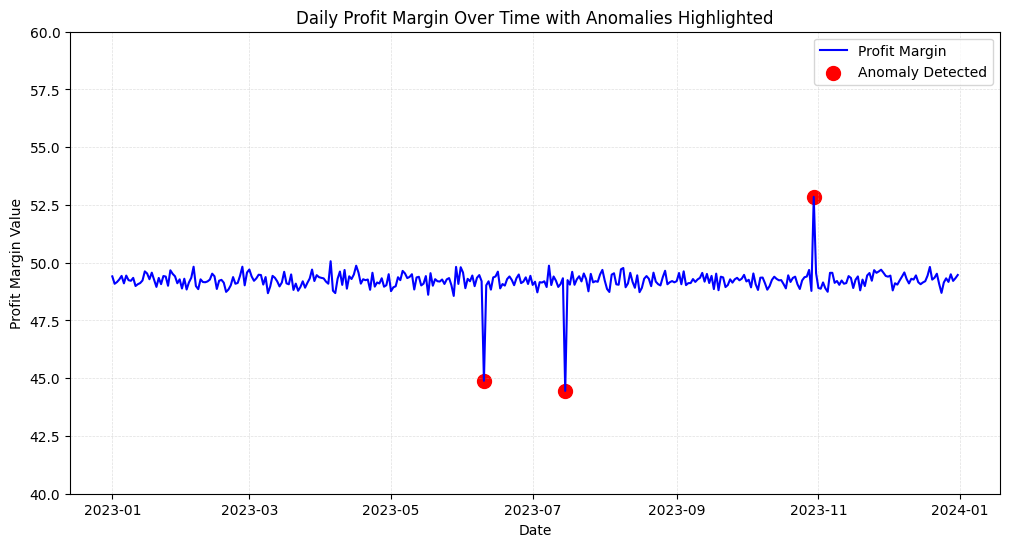

In [8]:
detector.visualize(figsize=(12,6), ylim=(40,60))

In [9]:
# Add edges
edges = [
    ("PRICEEACH", "UNIT_COST"), ("PRICEEACH", "SALES"),
    ("UNIT_COST", "COST_OF_GOODS_SOLD"),

    ("QUANTITYORDERED", "SALES"), ("QUANTITYORDERED", "COST_OF_GOODS_SOLD"),

    ("SALES", "DISCOUNT"),
    ("SALES", "NET_SALES"),

    ("DISCOUNT", "NET_SALES"),

    ("NET_SALES", "FULFILLMENT_COST"),
    ("NET_SALES", "MARKETING_COST"), ("NET_SALES", "RETURN_COST"),
    ("NET_SALES", "PROFIT"), ("FULFILLMENT_COST", "PROFIT"),
    ("MARKETING_COST", "PROFIT"), ("RETURN_COST", "PROFIT"),
    ("COST_OF_GOODS_SOLD", "PROFIT"), ("SHIPPING_REVENUE", "PROFIT"),
    ("PROFIT", "PROFIT_MARGIN"), ("NET_SALES", "PROFIT_MARGIN")
]

# Initialize the SCM builder with visualization enabled
builder = ScmBuilder(edges=edges, nodes=None, visualize=False)
scm = builder.build(df=df_agg) 

Automatically assigning causal mechanisms...
Fitting the Structural Causal Model...


Fitting causal mechanism of node PROFIT_MARGIN: 100%|██████████| 13/13 [00:00<00:00, 155.96it/s]


In [10]:
analyzer = CausalRootCauseAnalyzer(scm, min_score_threshold=0.3)
results = analyzer.analyze(df_agg, anomaly_dates, start_node='PROFIT_MARGIN')

Calculating noise-based contributions...


Evaluating set functions...: 100%|██████████| 266/266 [02:16<00:00,  1.95it/s]


Calculating structural anomaly scores...

Identifying root cause paths...

Found 5 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.2827):
├─ PROFIT_MARGIN        (Combined Score: 0.8710, Noise Contribution: 0.0381)
  ├─ PROFIT               (Combined Score: 0.8775, Noise Contribution: 0.0407)
    ├─ COST_OF_GOODS_SOLD   (Combined Score: 0.8695, Noise Contribution: 0.0431)
      └─ UNIT_COST            (Combined Score: 0.8009, Noise Contribution: 0.0952)

Path 2 (Causal Significance: 0.2392):
├─ PROFIT_MARGIN        (Combined Score: 0.8710, Noise Contribution: 0.0381)
  ├─ NET_SALES            (Combined Score: 0.8302, Noise Contribution: 0.0045)
    └─ DISCOUNT             (Combined Score: 0.6121, Noise Contribution: 0.0562)

Path 3 (Causal Significance: 0.2086):
├─ PROFIT_MARGIN        (Combined Score: 0.8710, Noise Contribution: 0.0381)
  ├─ PROFIT        

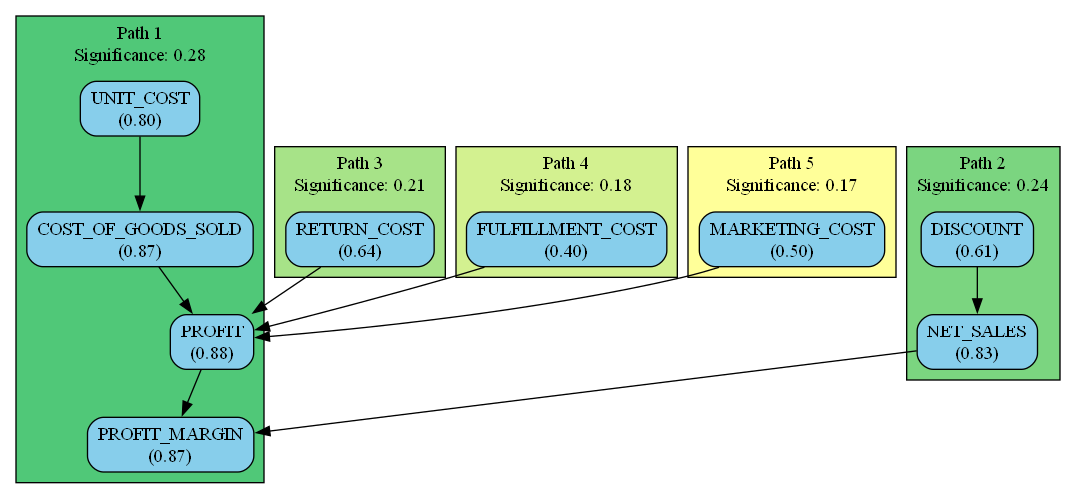

In [12]:
visualizer = CausalResultsVisualizer(results)
visualizer.plot_root_cause_paths()

In [13]:
analyzer = CausalRootCauseAnalyzer(scm, min_score_threshold=0.8)
results_by_date = analyzer.analyze_by_date(df_agg, anomaly_dates, start_node='PROFIT_MARGIN')

# You can then inspect the results for each anomaly date:
for ad, result in results_by_date.items():
    print(f"\nResults for anomaly date {ad}:")
    for path, score in result['paths']:
        print(f"Path with significance {score:.4f}: {path}")


--- Analyzing anomaly date: 2023-06-10 00:00:00 ---


Evaluating set functions...: 100%|██████████| 267/267 [00:42<00:00,  6.31it/s]
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



Found 1 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.0869):
├─ PROFIT_MARGIN        (Combined Score: 0.8526, Noise Contribution: 0.0379)
  ├─ NET_SALES            (Combined Score: 0.8267, Noise Contribution: 0.0998)
    └─ DISCOUNT             (Combined Score: 0.8479, Noise Contribution: 0.1241)

--- Analyzing anomaly date: 2023-07-15 00:00:00 ---


Evaluating set functions...: 100%|██████████| 267/267 [00:53<00:00,  5.02it/s]
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



Found 1 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.1747):
├─ PROFIT_MARGIN        (Combined Score: 0.8655, Noise Contribution: 0.0382)
  ├─ PROFIT               (Combined Score: 0.9086, Noise Contribution: 0.0409)
    ├─ COST_OF_GOODS_SOLD   (Combined Score: 0.8711, Noise Contribution: 0.1247)
      └─ UNIT_COST            (Combined Score: 0.8381, Noise Contribution: 0.2496)

--- Analyzing anomaly date: 2023-10-30 00:00:00 ---


Evaluating set functions...: 100%|██████████| 266/266 [00:44<00:00,  6.03it/s]



Found 1 potential root cause paths.

Detailed path analysis (ordered by causal significance):
------------------------------------------------------------

Path 1 (Causal Significance: 0.0582):
├─ PROFIT_MARGIN        (Combined Score: 0.8098, Noise Contribution: 0.0382)
  ├─ PROFIT               (Combined Score: 0.8318, Noise Contribution: 0.0390)
    └─ RETURN_COST          (Combined Score: 0.8654, Noise Contribution: 0.0831)

Results for anomaly date 2023-06-10 00:00:00:
Path with significance 0.0869: [('PROFIT_MARGIN', 0.8525890985409916), ('NET_SALES', 0.8267335005005997), ('DISCOUNT', 0.8478824705219938)]

Results for anomaly date 2023-07-15 00:00:00:
Path with significance 0.1747: [('PROFIT_MARGIN', 0.8655363220562886), ('PROFIT', 0.9086324631480702), ('COST_OF_GOODS_SOLD', 0.8710845500906816), ('UNIT_COST', 0.8381299430302921)]

Results for anomaly date 2023-10-30 00:00:00:
Path with significance 0.0582: [('PROFIT_MARGIN', 0.8098358771852627), ('PROFIT', 0.8317587930820833), ('

c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\ProRca\prorca\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Results for 2023-06-10 00:00:00:


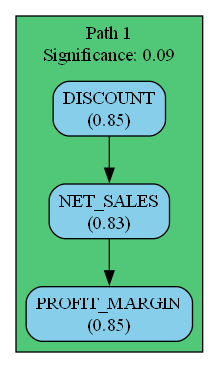

Results for 2023-07-15 00:00:00:


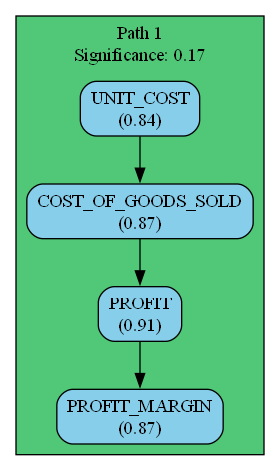

Results for 2023-10-30 00:00:00:


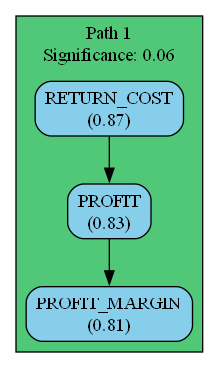

In [14]:
for date, result in results_by_date.items():
    print(f"Results for {date}:")
    vis = CausalResultsVisualizer(analysis_results=result)
    vis.plot_root_cause_paths()